<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-3/blob/main/vae_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3, Problem 4: VAE with SVM Head

## Download Data

In [5]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O /content/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O /content/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O /content/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O /content/test-labels-idx1-ubyte.gz

--2024-10-18 11:39:25--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.134.246, 3.5.134.168, 52.219.168.50, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.134.246|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

/content/train-imag 100%[===================>]  25.20M  4.16MB/s    in 7.2s    

2024-10-18 11:39:33 (3.50 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-18 11:39:33--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.204, 52.219.

## Library Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import wandb

torch.manual_seed(123)
np.random.seed(123)

# wandb.login()

## Check for GPU Access

In [2]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: True
MPS GPU Available: False
GPU Name: Tesla T4
GPU Count: 1
GPU Memory Allocated: 0
GPU Memory Cached: 0


## Load Data

### Define FashionMNIST

In [6]:
class FasionMNISTDataset(Dataset):
    def __init__(self, path: str, kind: str, device=torch.device('cpu')) -> None:
        super().__init__()
        self.device = device
        self.labels, self.images = self._load_data(path, kind)

    def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
        with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
            lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
            lbls = np.copy(lbls)
        with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
            imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
            imgs = (np.copy(imgs) / 255).astype(np.float32)
        return lbls, imgs

    def __len__(self) -> int:
        return self.labels.size

    def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
        img = torch.tensor(self.images[index])
        img = img.to(self.device)
        if self.labels is not None:
            label = torch.tensor(self.labels[index], dtype=torch.long)
            label = label.to(self.device)
            return img, label
        else:
            return img

    def stratified_indices(self, num_labels, removed_indicies=[]):
        """
        Create a stratified subset of the dataset using num_labels data points
        """
        # Get remaining indices after removing removed_indicies
        remaining_indices = np.setdiff1d(np.arange(len(self)), removed_indicies)

        indices = []
        for cls in range(10):
            cls_indices = remaining_indices[self.labels[remaining_indices] == cls]
            num_to_select = min(len(cls_indices), num_labels // 10)
            selected_indices = np.random.choice(cls_indices, num_to_select, replace=False)
            indices.extend(selected_indices.tolist())
        return indices

    def create_subsets(self, num_labels):
        """Create labeled and unlabeled subsets with no overlapping indices."""
        assert num_labels <= len(self), "Number of labels must be less than or equal to the dataset size"

        labeled_indices = self.stratified_indices(num_labels)

        all_indices = set(range(len(self)))
        remaining_indices = list(all_indices - set(labeled_indices))

        remaining_dataset = self.labels[remaining_indices]
        unlabeled_indices = self.stratified_indices(num_labels, labeled_indices)

        labeled_subset = torch.utils.data.Subset(self, labeled_indices)
        unlabeled_subset = torch.utils.data.Subset(self, unlabeled_indices)

        return labeled_subset, unlabeled_subset

def show_img(dataset: Dataset, index: int) -> None:
    img, label = dataset[index]
    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
    plt.imshow(img.cpu().reshape(28,28), cmap='gray')
    plt.title(labels_map[label.cpu().item()])
    plt.show()

### Unlabeled/Labeled Split & Data Loaders

In [7]:
gen = torch.Generator().manual_seed(123)

def create_datasets(num_labels, batch_size, device):
    PATH = '/content'

    train = FasionMNISTDataset(PATH, 'train', device=device)
    labeled, unlabeld = train.create_subsets(num_labels)
    test = FasionMNISTDataset(PATH, 'test', device=device)

    batch = batch_size
    labeledloader = DataLoader(labeled, batch, shuffle=True, generator=gen)
    unlabeledloader = DataLoader(unlabeld, batch, shuffle=True, generator=gen)
    testloader = DataLoader(test, batch, shuffle=True, generator=gen)

    data = {
        'labeled': labeled,
        'unlabeled': unlabeld,
        'test': test
    }

    dataloaders = {
        'labeled': labeledloader,
        'unlabeled': unlabeledloader,
        'test': testloader
    }
    return data, dataloaders

data, dataloaders = create_datasets(100, 8, device)


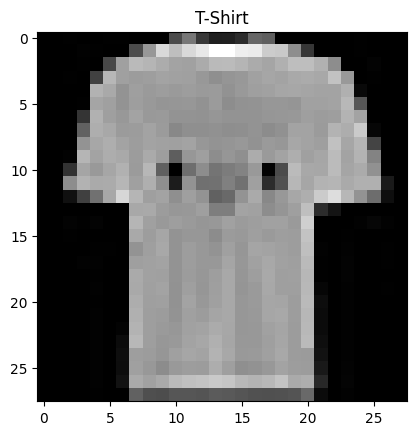

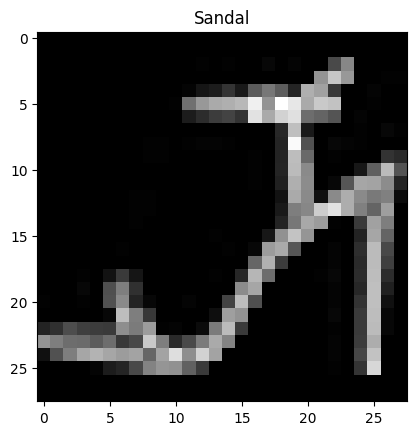

In [8]:
show_img(data['labeled'], 0)
show_img(data['labeled'],50)

## Define Model: Encoder, Decoder, & Gaussian Pytorch Modules

In [9]:
class Gaussian(nn.Module):
    def __init__(self, inputs: int, outputs:int):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs

        #create mu & log_var
        self.mu = nn.Linear(inputs, outputs)
        self.log_var = nn.Linear(inputs, outputs)

    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        log_var = F.softplus(log_var)


        return self.trick(mu, log_var), mu, log_var

    def trick(self, mu, log_var):
        """
        Return a sample from the gausian returned by mu & log_var
        """
        std_dev = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std_dev)
        return epsilon.mul(std_dev).add_(mu)


class Encoder(nn.Module):
    def __init__(self, inputs: int, hidden: list[int], latent: int):
        super().__init__()
        self.inputs = inputs
        self.hidden = hidden
        self.latent = latent

        self.fc0 = nn.Linear(inputs, hidden[0])

        for idx in range(1, len(hidden)):
            self.__setattr__(f'fc{idx}', nn.Linear(hidden[idx-1], hidden[idx]))
        self.gaussian = Gaussian(hidden[-1], latent)

        self.softplus = nn.Softplus()

    def forward(self, x):
        for idx in range(len(self.hidden)):
            x = self.softplus(self.__getattr__(f'fc{idx}')(x))
        return self.gaussian(x)

class Decoder(nn.Module):
    def __init__(self, latent: int, hidden: list[int], outputs: int):
        super().__init__()
        self.latent = latent
        self.hidden = hidden
        self.outputs = outputs

        self.fc0 = nn.Linear(latent, hidden[0])

        for idx in range(1, len(hidden)):
            self.__setattr__(f'fc{idx}', nn.Linear(hidden[idx-1], hidden[idx]))

        self.fc_out = nn.Linear(hidden[-1], outputs)

        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for idx in range(len(self.hidden)):
            x = self.softplus(self.__getattr__(f'fc{idx}')(x))
        return self.sigmoid(self.fc_out(x))

class VAE(nn.Module):
    def __init__(self, inputs: int, hidden: list[int], latent: int):
        super().__init__()

        self.inputs = inputs
        self.hidden = hidden
        self.latent = latent

        self.encoder = Encoder(inputs, hidden, latent)
        self.decoder = Decoder(latent, hidden[::-1], inputs)

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), z, mu, log_var


## Training

In [24]:
def vae_loss(x_hat, x, z, mu, log_var):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

def get_tensor_info(tensor):
    print(f"Shape: {tensor.shape}")
    print(f"Data Type: {tensor.dtype}")
    print(f"Device: {tensor.device}")
    print(f"Min: {tensor.min()}")
    print(f"Max: {tensor.max()}")
    print(f"Mean: {tensor.mean()}")
    print(f"Standard Deviation: {tensor.std()}")

def train_one_epoch(model, dataloaders, loss_fn, optimizer, epoch, device, verbosity):
    model.train()
    running_loss = 0.0

    for i, ((x_labeled, y_labeled), (x_unlabeled, _)) in enumerate(zip(dataloaders['labeled'], dataloaders['unlabeled'])):


        optimizer.zero_grad()

        x_hat_lbl, z_lbl, mu_lbl, log_var_lbl = model(x_labeled.view(-1, 28 * 28))
        x_hat_unlbl, z_unlbl, mu_unlbl, log_var_unlbl = model(x_unlabeled.view(-1, 28 * 28))

        loss = loss_fn(x_hat_lbl, x_labeled.view(-1, 28 * 28), z_lbl, mu_lbl, log_var_lbl)
        loss += loss_fn(x_hat_unlbl, x_unlabeled.view(-1, 28 * 28), z_unlbl, mu_unlbl, log_var_unlbl)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if verbosity > 0:
            if (i + 1) % verbosity == 0:
                print(f'Batch #{i + 1} Loss: {running_loss / verbosity}')
                running_loss = 0.0


def get_latent(model, device, data):
    model.eval()

    latent = []
    labels = []

    with torch.no_grad():
        for x, y in data:
            x, y = x.to(device), y.to(device)

            z, _, _ = model.encoder(x.view(-1, 28 * 28))
            latent.append(z)
            labels.append(y)

    return torch.cat(latent).cpu().numpy(), torch.cat(labels).cpu().numpy()

def train_vae(model, dataloaders, loss_fn, optimizer, device, epochs: int, verbosity: int):
    """Train network for given number of epochs using optimizer and loss_fn"""

    print('----------- VAE Train Start! ------------')
    for epoch in range(epochs):
        if verbosity > 0:
            print(f'----------- Epoch #{epoch + 1} ------------')

        train_one_epoch(model, dataloaders, loss_fn, optimizer, device, epoch, verbosity)

        if verbosity > 0:
            print('------------------------------------\n')
    print('----------- VAE Train Complete! ------------')

    return get_latent(model, device, dataloaders['labeled'])


def train_svm_head(latent, labels, kernel, C=1):
    svm = SVC(kernel=kernel, random_state=123, C=C)
    svm.fit(latent, labels)
    return svm

def eval_metrics(model, train_labels, train_preds, test_labels, test_preds):
    print(f"------ Classification Metrics ------")
    print('Metric\t\tTrain\t\tTest')
    print('Accuracy:\t',round(accuracy_score(train_labels,train_preds),5),'\t',round(accuracy_score(test_labels, test_preds),5))
    print('Recall:\t\t',round(recall_score(train_labels,train_preds, average='macro'),5),'\t',round(recall_score(test_labels, test_preds, average='macro'),5))
    print('Precision:\t',round(precision_score(train_labels,train_preds, average='macro'),5),'\t',round(precision_score(test_labels, test_preds, average='macro'),5))
    print('F1 Score:\t',round(f1_score(train_labels,train_preds, average='macro'),5),'\t',round(f1_score(test_labels, test_preds, average='macro'),5))
    print('------------------------------------\n')

    return accuracy_score(test_labels, test_preds)

In [25]:
input = 28 * 28
hidden = [630, 630]
latent = 10
num_labels = [100, 600, 1000, 3000]
epochs = 500
verbosity = 10
batch = 64

In [26]:
import pickle
torch.cuda.empty_cache()

def run_training(vae_model, num_samples, optim, epochs, verbosity, device):
    data, dataloaders = create_datasets(num_samples, batch, device)
    train_latent_vectors, train_labels = train_vae(vae_model, dataloaders, vae_loss, optim, device, epochs, verbosity)

    print('Training SVM Head (C=1)...')
    svm1 = train_svm_head(train_latent_vectors, train_labels,'rbf')
    train_preds = svm1.predict(train_latent_vectors)
    test_latent_vectors, test_labels = get_latent(vae, device, dataloaders['test'])
    test_preds = svm1.predict(test_latent_vectors)
    acc1 = eval_metrics(svm1, train_labels, train_preds, test_labels, test_preds)

    print('Training SVM Head (C=0.5)...')
    svm2 = train_svm_head(train_latent_vectors, train_labels,'rbf',C=0.5)
    train_preds = svm2.predict(train_latent_vectors)
    test_latent_vectors, test_labels = get_latent(vae, device, dataloaders['test'])
    test_preds = svm2.predict(test_latent_vectors)
    acc2 = eval_metrics(svm2, train_labels, train_preds, test_labels, test_preds)

    return svm1 if acc1 > acc2 else svm2

svms = []
for i in num_labels:
    print(f"Training with {i} labeled samples")
    vae = VAE(input, hidden, latent)
    adam = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=.01)
    vae = vae.to(device)
    svm = run_training(vae, i, adam, epochs, 0, device)
    svms.append(svm)

    torch.save(vae.state_dict(), f'/content/drive/MyDrive/DL3/vae_{i}.pth')
    with open(f'/content/drive/MyDrive/DL3/svm_{i}.pkl', 'wb') as f:
        pickle.dump(svm, f)

Training with 100 labeled samples
----------- VAE Train Start! ------------
----------- VAE Train Complete! ------------
Training SVM Head (C=1)...
------ Classification Metrics ------
Metric		Train		Test
Accuracy:	 0.91 	 0.5957
Recall:		 0.91 	 0.5957
Precision:	 0.92056 	 0.59621
F1 Score:	 0.90762 	 0.58582
------------------------------------

Training SVM Head (C=0.5)...
------ Classification Metrics ------
Metric		Train		Test
Accuracy:	 0.85 	 0.5924
Recall:		 0.85 	 0.5924
Precision:	 0.87106 	 0.58798
F1 Score:	 0.83632 	 0.57807
------------------------------------

Training with 600 labeled samples
----------- VAE Train Start! ------------
----------- VAE Train Complete! ------------
Training SVM Head (C=1)...
------ Classification Metrics ------
Metric		Train		Test
Accuracy:	 0.83667 	 0.6972
Recall:		 0.83667 	 0.6972
Precision:	 0.83424 	 0.69709
F1 Score:	 0.83355 	 0.69524
------------------------------------

Training SVM Head (C=0.5)...
------ Classification Metrics -

[7 3 9 6 4 6 7 9 7 4]


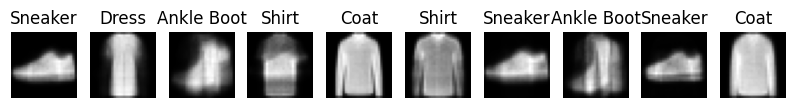

In [40]:
import matplotlib.pyplot as plt

def generate_images(model, head, num_images, latent_dim, device):
    # Set the model to evaluation mode
    model.eval()

    # Sample from a standard normal distribution in the latent space
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)  # latent_dim is the size of the latent vector
        generated_images = model.decoder(z)  # Pass through decoder to get reconstructed images
        generated_images = generated_images.view(num_images, 28, 28).cpu()  # Reshape and move to CPU

    preds = head.predict(z.cpu())

    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].set_title(labels_map[preds[i]])
        axes[i].axis('off')
    plt.show()

# Example usage:
num_images = 10  # Specify how many images you want to generate
latent_dim = 10  # Latent dimension used during training
generate_images(vae, svms[-1], num_images, latent_dim, device)

## Load Saved Models & Testing

<ipython-input-42-b6123e73778b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tmp.load_state_dict(torch.load('/content/drive/MyDrive/DL3/vae_1000.pth'))


[7 3 4 5 2 7 6 0 4 1]


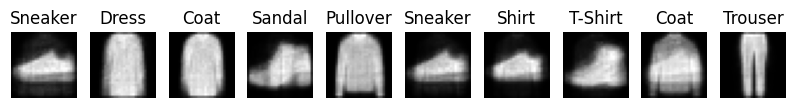

In [42]:
tmp = VAE(input, hidden, latent).to(device)
tmp.load_state_dict(torch.load('/content/drive/MyDrive/DL3/vae_1000.pth'))

with open('/content/drive/MyDrive/DL3/svm_1000.pkl', 'rb') as f:
    head = pickle.load(f)
generate_images(tmp, head, 10, latent, device)